### 쿠키 캣츠 모바일 게임의 A/B 테스트

- 인앱 구매를 요구하는 encounter gates를 넣는 시기의 A/B 테스팅. "레벨 30에서 40으로 이동시켰을 때"

In [55]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#### 1.1 데이터 확인
- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

In [56]:
folder = 'C:/Users/su/OneDrive - 청주대학교 (1)/datasets/before/2023'
file_name = '[2023_08_10]Mobile_Games_AB_Testing'
cookie_cats_data = 'cookie_cats.csv'

In [57]:
encoding="unicode_escape"
encoding="ISO-8859-1"
encoding='utf-8'
cookie_cats_data = pd.read_csv(os.path.join(folder, file_name, cookie_cats_data), encoding=encoding)

In [58]:
cookie_cats_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [59]:
cookie_cats_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [60]:
# 두 대조군이 적당히 나누어져 있음을 확인
divide_ab = cookie_cats_data.groupby('version').count()
divide_ab

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [61]:
# 두 그룹간 비율 차이
total = len(cookie_cats_data)
a, b = cookie_cats_data.groupby('version').count().userid
print(f'{abs((a-b) / total)*100:.2f}% diff')

0.87% diff


#### 1.2 데이터 전처리 및 유저의 패턴 분석

- 데이터 이상치 제거

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

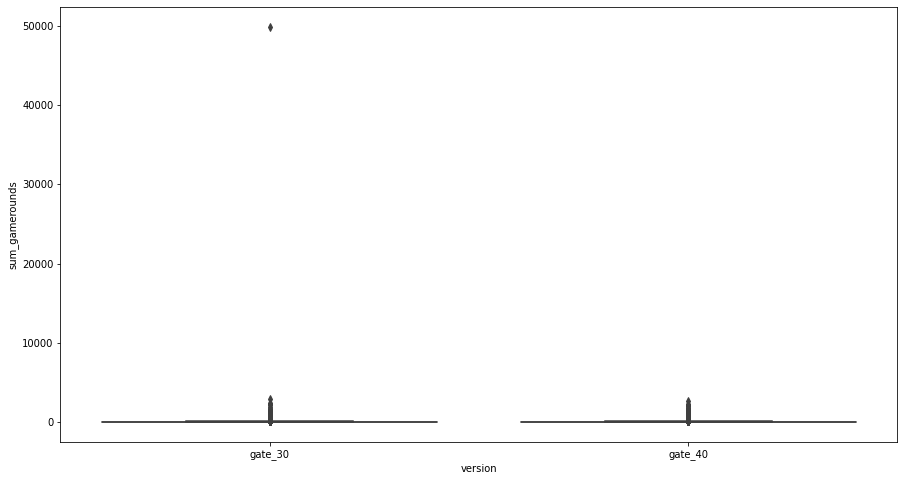

In [62]:
# 데이터 이상치 확인
plt.figure(figsize=(15, 8))
sns.boxplot(x=cookie_cats_data.version, y=cookie_cats_data.sum_gamerounds)

In [63]:
# 이상치 데이터 제거
cookie_cats_data[cookie_cats_data.sum_gamerounds > 10000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [64]:
cookie_cats_data.drop(cookie_cats_data[cookie_cats_data.sum_gamerounds > 10000].index, inplace=True)

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

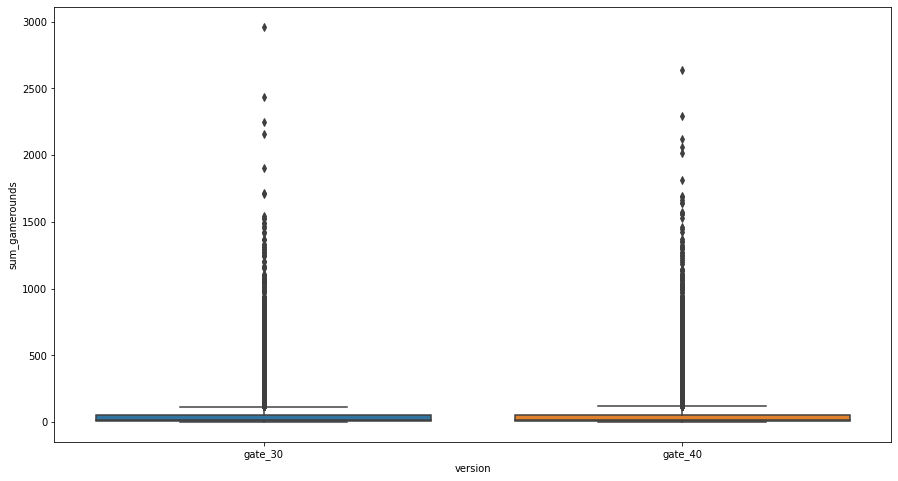

In [65]:
# 데이터 이상치 재확인
plt.figure(figsize=(15, 8))
sns.boxplot(x=cookie_cats_data.version, y=cookie_cats_data.sum_gamerounds)

In [66]:
# 데이터의 편중 확인
cookie_cats_data['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

- 게임 시작 후 첫 주동안 그룹별 라운드 진행 횟수 확인

In [142]:
divide_version_sum_gamerounds = cookie_cats_data.groupby(['version','sum_gamerounds']).userid.count()
print('gate_30')
print(divide_version_sum_gamerounds['gate_30'].head())
print('--------------------------')
print('gate_40')
print(divide_version_sum_gamerounds['gate_40'].head())

gate_30
sum_gamerounds
0    1937
1    2749
2    2198
3    1899
4    1831
Name: userid, dtype: int64
--------------------------
gate_40
sum_gamerounds
0    2057
1    2789
2    2408
3    2059
4    1798
Name: userid, dtype: int64


- 25%이하의 유저가 약 5라운드 정도, 50%이하의 유저가 16라운드 정도, 75%이하의 유저가 51라운드 정도까지 게임을 진행한 것을 확인 할 수 있음
- 이를 통해 대다수의 유저가 적은 라운드의 수로 게임을 진행하는 것을 확인 할 수 있음
- 게임을 설치 후 아예 플레이하지 않은 유저가 약 4천명(5%)

Text(0.5, 1.0, '75% of players that played the game')

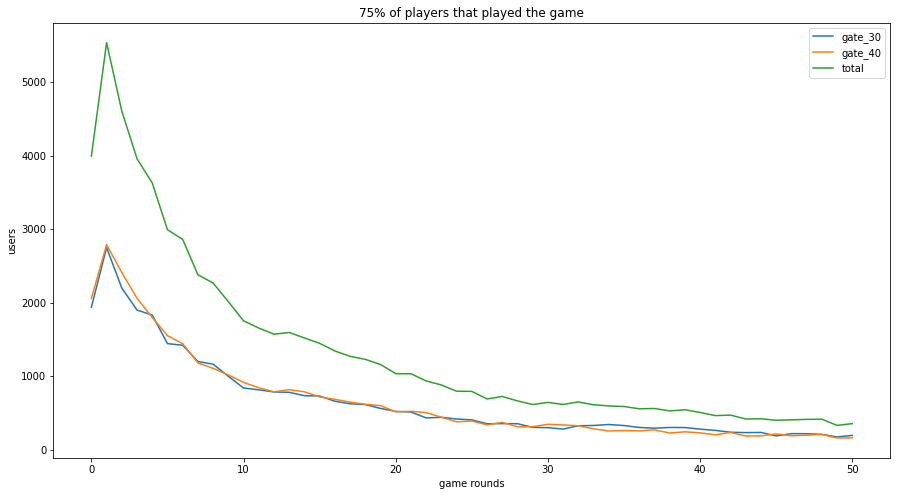

In [185]:
# 첫주에 상위 25%이하의 유저가 플레이한 게임 라운드의 분포 수 그래프
plt.figure(figsize=(15, 8))
size=int(cookie_cats_data['sum_gamerounds'].describe()['75%'])

sns.lineplot(data=divide_version_sum_gamerounds['gate_30'][:size])
sns.lineplot(data=divide_version_sum_gamerounds['gate_40'][:size])
sns.lineplot(data=cookie_cats_data.groupby('sum_gamerounds').userid.count()[:size],)

plt.legend(['gate_30', 'gate_40', 'total'])
plt.ylabel('users')
plt.xlabel('game rounds')
plt.title('75% of players that played the game')

- 2개의 그룹 모두 비슷한 양상을 띄며, 대다수의 유저가 30게임 이내로 플레이 한 것을 볼 수 있음
- 30게임 이후로는 완만한 그래프를 보여주며 급감하지 않음 

#### 1.3 retention 1 비교

- 1 day retention이 높을 수록, 게임의 재미도와 매력이 높다고 할 수 있음

In [189]:
# 그룹별 사용자의 평균 회귀 확률
cookie_cats_data.groupby('version').retention_1.mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

- 그룹 30은 약 44.8%, 그룹 40은 약 44.2% 정도의 사용자가 하루가 지나도 다시 게임을 플레이 함.
- 새로운 제안이 오히려 retention을 떨어뜨림을 확인
- bootstrapping을 사용하여 retention 평균의 값을 좀 더 확실히 측정

In [216]:
# bootstrapping
sample_distribution_retention_1 = pd.DataFrame(
    [cookie_cats_data.sample(frac=0.5, replace=False).groupby('version').retention_1.mean() for i in range(1000)]
)
sample_distribution_retention_1.head()

version,gate_30,gate_40
retention_1,0.449106,0.442502
retention_1,0.445579,0.441056
retention_1,0.447154,0.440934
retention_1,0.448098,0.441180
retention_1,0.447660,0.440049


Text(0.5, 1.0, 'one day retention for each group')

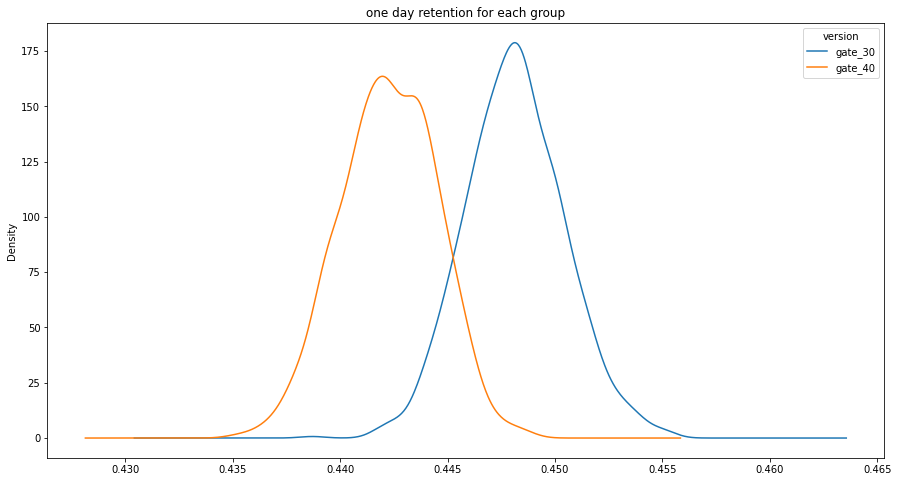

In [218]:
# 두 그룹간 평균값의 차이를 그래프화. 정규 분포를 이룸.
ax = sample_distribution_retention_1.plot(
    kind='density',
    figsize=(15, 8),
    )
ax.set_title('one day retention for each group')

In [232]:
# ab 그룹 간 차이 column 생성
sample_distribution_retention_1['diff'] = (sample_distribution_retention_1.gate_30 - sample_distribution_retention_1.gate_40)*100
sample_distribution_retention_1['diff'].head()

retention_1    0.660392
retention_1    0.452240
retention_1    0.621998
retention_1    0.691786
retention_1    0.761054
Name: diff, dtype: float64

Text(0.5, 1.0, '% difference between the AB-groups')

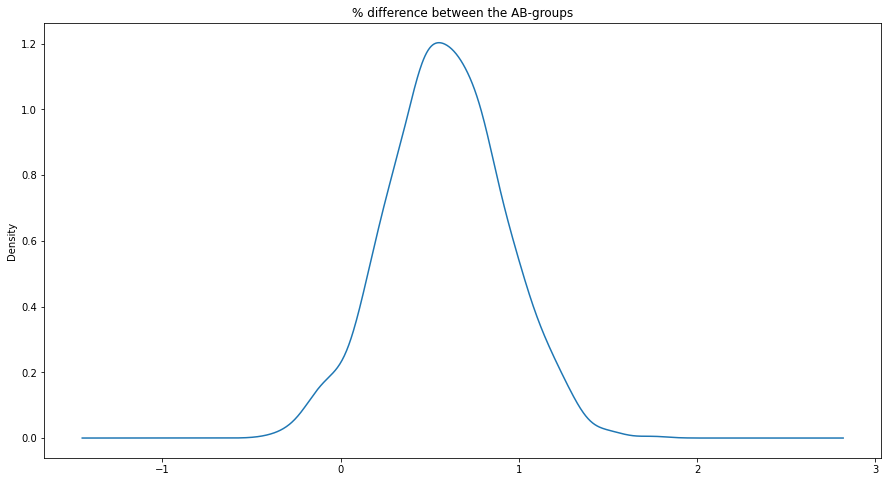

In [233]:
# diff 컬럼 그래프화를 통한 비교
ax = sample_distribution_retention_1['diff'].plot(
    kind='density',
    figsize=(15, 8),
    )
ax.set_title('% difference between the AB-groups')

In [253]:
print(f'gate 30에서의 retention이 더 많은 확률: {(sample_distribution_retention_1["diff"] > 0).mean()*100}%')

gate 30에서의 retention이 더 많은 확률: 96.1%


In [246]:
from scipy import stats
tTestResultDiffVar = stats.ttest_ind(sample_distribution_retention_1.gate_30, sample_distribution_retention_1.gate_40, equal_var=True)
tTestResultDiffVar

Ttest_indResult(statistic=57.95876017754326, pvalue=0.0)

- 이는 약 96% 수준의 신뢰 수준을 보임
- statistic의 값이 높아 두 개의 그룹은 차이가 난다고 볼 수 있음
- p-value의 값이 낮아 두 모집단이 유의미한 차이를 보임을 확인

#### 1.4 retention 7 비교

In [254]:
# 그룹별 사용자의 평균 회귀 확률
cookie_cats_data.groupby('version').retention_7.mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

- 그룹 30은 약 19.0%, 그룹 40은 약 18.2% 정도의 사용자가 일주일이 지나도 다시 게임을 플레이 함.
- 새로운 제안이 오히려 retention을 떨어뜨림을 확인
- 마찬가지로 bootstrapping을 사용하여 retention 평균의 값을 좀 더 확실히 측정

In [262]:
# bootstrapping
sample_distribution_retention_7 = pd.DataFrame(
    [cookie_cats_data.sample(frac=0.5, replace=False).groupby('version').retention_7.mean() for i in range(1000)]
)
sample_distribution_retention_7.head()

version,gate_30,gate_40
retention_7,0.191300,0.183267
retention_7,0.189778,0.182563
retention_7,0.192146,0.179847
retention_7,0.188653,0.181240
retention_7,0.193270,0.183365


Text(0.5, 1.0, 'seven day retention for each group')

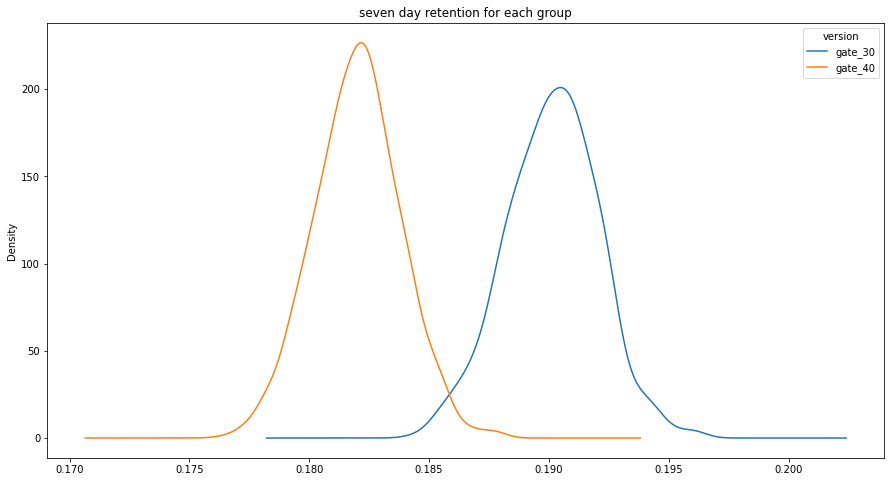

In [263]:
# 두 그룹간 평균값의 차이를 그래프화. 정규 분포를 이룸.
ax = sample_distribution_retention_7.plot(
    kind='density',
    figsize=(15, 8),
    )
ax.set_title('seven day retention for each group')

In [257]:
# ab 그룹 간 차이 column 생성
sample_distribution_retention_7['diff'] = (sample_distribution_retention_7.gate_30 - sample_distribution_retention_7.gate_40)*100
sample_distribution_retention_7['diff'].head()

retention_7    0.361658
retention_7    0.526856
retention_7    0.764546
retention_7    0.971816
retention_7    0.858672
Name: diff, dtype: float64

Text(0.5, 1.0, '% difference between the AB-groups')

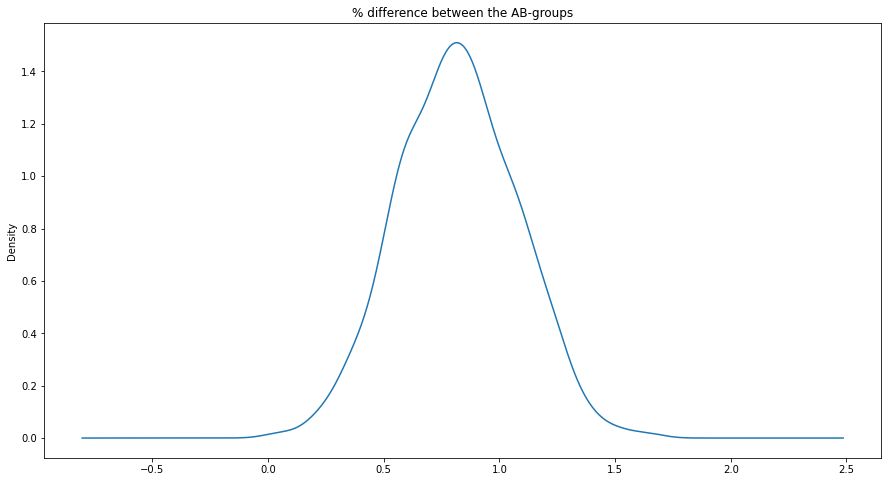

In [258]:
# diff 컬럼 그래프화를 통한 비교
ax = sample_distribution_retention_7['diff'].plot(
    kind='density',
    figsize=(15, 8),
    )
ax.set_title('% difference between the AB-groups')

In [259]:
print(f'gate 30에서의 retention이 더 많은 확률: {(sample_distribution_retention_7["diff"] > 0).mean()*100}%')

gate 30에서의 retention이 더 많은 확률: 100.0%


In [260]:
from scipy import stats
tTestResultDiffVar = stats.ttest_ind(sample_distribution_retention_7.gate_30, sample_distribution_retention_7.gate_40, equal_var=True)
tTestResultDiffVar

Ttest_indResult(statistic=101.25494101554494, pvalue=0.0)

- 이는 약 100% 수준의 신뢰 수준을 보임
- statistic의 값이 매우 높아 두 개의 그룹은 차이가 난다고 볼 수 있음
- p-value의 값이 낮아 두 모집단이 유의미한 차이를 보임을 확인

##### 2.결론

- 부트스트랩 결과는 게이트가 30일 때가 40일 때보다 더 높으므로, 30에서 40으로 이동하지 말아야 함.

- 라운드를 적게 플레이하는 유저들이 오래 플레이하는 유저보다 훨씬 많은데, 게임의 진행 속도를 30에서 40으로 더 늦추게 된다면, 그 전에 유저들이 접을 경향이 커 보임.

- 오히려 30보다 이전으로 게이트를 이동시킨다면 좋은 결과를 보일 수도 있을 것 같음.